In [ ]:
# Full example using charuco images to calibrate the distortion and focal length
# from the video file from a camera, and also use to calculate the pose estimations

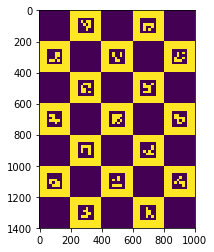

In [19]:
#
# Use this to generate a charuco image for you
#
import cv2
aruco_dict = cv2.aruco.Dictionary_get(cv2.aruco.DICT_4X4_50)
squaresX, squaresY = 5, 7
markersquareratio = 0.5
charboard = cv2.aruco.CharucoBoard_create(squaresX, squaresY, 0.025, 0.025*markersquareratio, aruco_dict)
img = charboard.draw((200*5, 200*7))
cv2.imwrite('charuco.png',img)

from matplotlib import pyplot as plt
%matplotlib inline
plt.imshow(img)

In [5]:
#
# Use this cell to find chessboards and calculate the camera distortion
#
vfile = "/home/julian/repositories/Future-Hangglider/CameraCalibrationTech/videos/turnigy_charuco.MOV"
squaresX, squaresY = 5, 7
chesssquareLength = 0.0573

import cv2, numpy
cap = cv2.VideoCapture(vfile)

nframes = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
imageSize = (int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)))
print("nframes", nframes, "w,h =", imageSize)

chesspatternSize = (squaresX-1, squaresY-1)
winSize, zeroZone, criteria = (5, 5), (-1, -1), (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_COUNT, 30, 0.1)
chesspatternPoints = numpy.zeros((numpy.prod(chesspatternSize), 3), numpy.float32)
chesspatternPoints[:,:2] = numpy.indices(chesspatternSize).T.reshape(-1, 2)
chesspatternPoints *= chesssquareLength

imagePoints, objectPoints = [ ], [ ]
for iframe in range(10, nframes, nframes//44):
    cap.set(cv2.CAP_PROP_POS_FRAMES, iframe)
    flag, frame = cap.retrieve()

    found, corners = cv2.findChessboardCorners(frame, chesspatternSize)
    if found:
        corners = cv2.cornerSubPix(img, corners, winSize, zeroZone, criteria)
        cv2.drawChessboardCorners(frame, chesspatternSize, corners, found) 
        imagePoints.append(corners.reshape(-1, 2))
        objectPoints.append(chesspatternPoints)
        #cv2.drawChessboardCorners(frame, chesspatternSize, corners, found) 

# Long calculation that gets the rvec and tvec of the chessboard in each frame
print("calculating camera coeffs for %d chessboards" % len(imagePoints))
retval, cameraMatrix, distCoeffs, rvecs, tvecs = cv2.calibrateCamera(objectPoints, imagePoints, imageSize, None, None)

print("cameraMatrix = numpy.%s" % repr(cameraMatrix))
print("distCoeffs = numpy.%s" % repr(distCoeffs))


nframes 587 w,h = (1920, 1080)
10 True
23 True
36 True
49 True
62 True
75 True
88 True
101 True
114 True
127 True
140 True
153 True
166 True
179 True
192 False
205 True
218 True
231 True
244 True
257 True
270 True
283 True
296 True
309 False
322 True
335 True
348 True
361 True
374 False
387 True
400 True
413 False
426 True
439 True
452 True
465 True
478 True
491 False
504 True
517 True
530 True
543 True
556 True
569 True
582 True
cameraMatrix = numpy.array([[1.01048336e+03, 0.00000000e+00, 9.46630412e+02],
       [0.00000000e+00, 1.01945395e+03, 5.71135893e+02],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])
distCoeffs = numpy.array([[-0.31967893,  0.13367133, -0.00175612,  0.00153122, -0.03052692]])


In [71]:
# 
# Use this cell to preview frames through the undistortion lens
#
import cv2, numpy
vfile = "/home/julian/repositories/Future-Hangglider/CameraCalibrationTech/videos/turnigy_charuco2.MOV"

cameraMatrix = numpy.array([[1.01048336e+03, 0.00000000e+00, 9.46630412e+02],
                            [0.00000000e+00, 1.01945395e+03, 5.71135893e+02],
                            [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])
distCoeffs = numpy.array([[-0.31967893,  0.13367133, -0.00175612,  0.00153122, -0.03052692]])

# may also use to test different distortion coeffs

from matplotlib import pyplot as plt
%matplotlib inline

cap = cv2.VideoCapture(vfile)
import ipywidgets as widgets
nframes = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

Wframenumber = widgets.IntSlider(description="frame", value=nframes//2, min=0, max=nframes, continuous_update=False)
Wframenumber.layout.width = "600px"
ui = widgets.VBox([Wframenumber])

squaresX, squaresY = 5, 7
markersquareratio = 0.5
chesssquareLength = 0.0573
aruco_dict = cv2.aruco.Dictionary_get(cv2.aruco.DICT_4X4_50)
charboard = cv2.aruco.CharucoBoard_create(squaresX, squaresY, chesssquareLength, chesssquareLength*markersquareratio, aruco_dict)
parameters =  cv2.aruco.DetectorParameters_create()

def plotframewindowundistort(cap, framenumber):
    plt.figure(figsize=(17,6))
    cap.set(cv2.CAP_PROP_POS_FRAMES, framenumber)
    flag, frame = cap.retrieve()
    
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    newcameraMatrix, validPixROI = cv2.getOptimalNewCameraMatrix(cameraMatrix, distCoeffs, imageSize, 0)
    frameUndistorted = cv2.undistort(frame, cameraMatrix, distCoeffs, newcameraMatrix)

    markerCorners, markerIds, rejectedMarkers = cv2.aruco.detectMarkers(frame, aruco_dict, parameters=parameters, cameraMatrix=cameraMatrix, distCoeff=distCoeffs)
    if markerIds is not None:
        cv2.aruco.refineDetectedMarkers(frame, charboard, markerCorners, markerIds, rejectedMarkers, cameraMatrix, distCoeffs)
        retval, charucoCorners, charucoIds = cv2.aruco.interpolateCornersCharuco(markerCorners, markerIds, frame, charboard, cameraMatrix=cameraMatrix, distCoeffs=distCoeffs)
        if retval is not None:
            cv2.aruco.drawDetectedCornersCharuco(frame, charucoCorners, charucoIds)

    plt.subplot(1, 2, 1)
    plt.imshow(frame)
    plt.gca().axes.get_xaxis().set_visible(False)
    plt.gca().axes.get_yaxis().set_visible(False)
    
    plt.subplot(1, 2, 2)
    plt.imshow(frameUndistorted)
    plt.gca().axes.get_xaxis().set_visible(False)
    plt.gca().axes.get_yaxis().set_visible(False)
    
    plt.subplots_adjust(0,0,1,1,0.05,0.05)

imageSize = (int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)))
params = {'framenumber':Wframenumber, 
          'cap':widgets.fixed(cap)}
outputfigure = widgets.interactive_output(plotframewindowundistort, params)
outputfigure.layout.height = '400px'
display(ui, outputfigure);


Output(layout=Layout(height='400px'))

nframes 1458 w,h = (1920, 1080)
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400


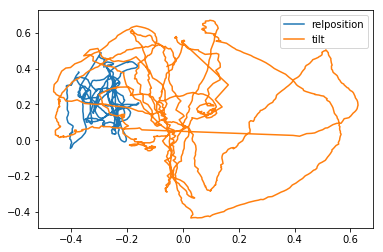

In [9]:
#
# Use this cell to extract the pose position (tilt and translate) from each frame where there is a charuco board
#

import cv2, numpy, pandas
vfile = "/home/julian/repositories/Future-Hangglider/CameraCalibrationTech/videos/turnigy_charuco2.MOV"

squaresX, squaresY = 5, 7
markersquareratio = 0.5
chesssquareLength = 0.0573

cameraMatrix = numpy.array([[1.01048336e+03, 0.00000000e+00, 9.46630412e+02],
                            [0.00000000e+00, 1.01945395e+03, 5.71135893e+02],
                            [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])
distCoeffs = numpy.array([[-0.31967893,  0.13367133, -0.00175612,  0.00153122, -0.03052692]])


aruco_dict = cv2.aruco.Dictionary_get(cv2.aruco.DICT_4X4_50)
charboard = cv2.aruco.CharucoBoard_create(squaresX, squaresY, chesssquareLength, chesssquareLength*markersquareratio, aruco_dict)
parameters =  cv2.aruco.DetectorParameters_create()

cap = cv2.VideoCapture(vfile)
nframes = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
imageSize = (int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)))
print("nframes", nframes, "w,h =", imageSize)

vals = [ ]
for i in range(nframes):
    flag, frame = cap.read()  # advances by 1 (initializes at 0, then reads the frame)
    if not flag:
        break
    framenum = int(cap.get(cv2.CAP_PROP_POS_FRAMES))
    if (framenum%100) == 0:
        print(framenum)
    markerCorners, markerIds, rejectedMarkers = cv2.aruco.detectMarkers(frame, aruco_dict, parameters=parameters, cameraMatrix=cameraMatrix, distCoeff=distCoeffs)
    if markerIds is None:   continue
    cv2.aruco.refineDetectedMarkers(frame, charboard, markerCorners, markerIds, rejectedMarkers, cameraMatrix, distCoeffs)
    retval, charucoCorners, charucoIds = cv2.aruco.interpolateCornersCharuco(markerCorners, markerIds, frame, charboard, cameraMatrix=cameraMatrix, distCoeffs=distCoeffs)
    if not retval:          continue
    retval, rvec, tvec = cv2.aruco.estimatePoseCharucoBoard(charucoCorners, charucoIds, charboard, cameraMatrix, distCoeffs)
    if not retval:          continue
    r = cv2.Rodrigues(rvec)[0][2]
    val = {"framenum":framenum, "tx":tvec[0][0], "ty":tvec[1][0], "tz":tvec[2][0], 
                                "rx":r[0], "ry":r[1], "rz":r[2]}
    vals.append(val)

tiltv = pandas.DataFrame.from_dict(vals)
tiltv.set_index("framenum", inplace=True)
tiltv.index.name = None
len(tiltv)

from matplotlib import pyplot as plt
%matplotlib inline

plt.plot(tiltv.tx, tiltv.ty, label="relposition")
plt.plot(tiltv.rx, tiltv.ry, label="tilt")
plt.legend()

In [2]:
# 
# The next cells from here on are about loading the corresponding logfile with the orientation sensor
# and aligning it timewise with the flashing LED
# and comparing it to the tilt axis from the accelerometer sensor
#

import sys
sys.path.append("/home/julian/repositories/Future-Hangglider/hacktrack")

from hacktrack import loaders, clickables, utils
import pandas
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
    
logfile = "/home/julian/repositories/Future-Hangglider/CameraCalibrationTech/videos/hdata-turnigy_charuco2.log"
fd = loaders.FlyDat(logfile)
fd.LoadC("U")
fd.LoadC("Z")


should be same None 2019-07-20 00:00:00
badline End(5579,461)

F:2060, V:1, Z:3507, U:11, aF:230, aZ:230
linAdifftime -8025.7873831775705 count 214
Made for Q 0 last index 0
Loading aQV as no pQV records
Made for aQ 0 last index 0
Missing GPS data, so setting t0 to 2019-07-20 12:13:19.740213
Made for U 11 last index 11
Warning, using guessed (not GPS) timing corrected value on U 11
pCattrname pU
BAD VALUES 101 [(32, 'Zt00016807xEB16y2300z9E0Ea1FC1bF0FEcF9FFw00EBx0E23yC19EzBB1Fs00\n'), (61, 'Zt00016969xFFE9y0016zBB2Da7016b6E00cB00Ew0070x0E6EyC1B0zFDC3sC3\n'), (138, 'Zt00016D13x004CyBB2Dz0E16a6805b61EFc443Dw050ExEF68y3D61z0544s4C\n')]
Made for Z 3507 last index 3406
Warning, using guessed (not GPS) timing corrected value on Z 3507
pCattrname pZ


1

In [3]:
#
# Use this cell to calculate the flashing LED times for logfile alignment
#
vfile = "/home/julian/repositories/Future-Hangglider/CameraCalibrationTech/videos/turnigy_charuco2.MOV"

import sys
sys.path.append("/home/julian/repositories/Future-Hangglider/hacktrack")

import cv2, numpy, pandas
cap = cv2.VideoCapture(vfile)

from hacktrack import videos
videos.frameselectinteractive(cap)


Output(layout=Layout(height='400px'))

scanning between frames (1, 1458)
1000


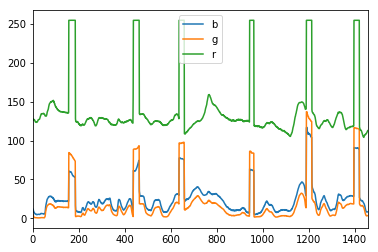

In [4]:
ledbrights = videos.extractledflashframes(cap)
ledbrights.plot()

In [11]:
videoledonvalues = ledbrights.r>200
ledswitchtimes = (fd.pU.Dust==1)  # one timestamped record for every on and off of the LED
frametimes = videos.framestotime(videoledonvalues, ledswitchtimes)

Framerate 30.00309225366042


In [7]:
# convert quaternions into tilt of Z
pZ = fd.pZ
r00 = pZ.q0*pZ.q0*2 * pZ.iqsq
r33 = pZ.q3*pZ.q3*2 * pZ.iqsq
r01 = pZ.q0*pZ.q1*2 * pZ.iqsq
r02 = pZ.q0*pZ.q2*2 * pZ.iqsq
r13 = pZ.q1*pZ.q3*2 * pZ.iqsq
r23 = pZ.q2*pZ.q3*2 * pZ.iqsq
pZ["tiltx"] = r13 + r02
pZ["tilty"] = r23 - r01
pZ["tiltz"] = r00 - 1 + r33


In [14]:
tiltv

,rx,ry,rz,tx,ty,tz,frametimes
1,-0.057341,0.412461,-0.909169,-0.283411,0.409321,0.378195,2019-07-20 12:14:47.135204
2,-0.038241,0.425239,-0.904273,-0.284404,0.431317,0.373048,2019-07-20 12:14:47.168534
3,-0.015313,0.466192,-0.884551,-0.282432,0.447668,0.363268,2019-07-20 12:14:47.201864
4,-0.007913,0.491548,-0.870815,-0.278797,0.457333,0.357852,2019-07-20 12:14:47.235194
5,-0.000632,0.537000,-0.843582,-0.278268,0.456645,0.346204,2019-07-20 12:14:47.268524
6,-0.001654,0.549902,-0.835228,-0.283265,0.454072,0.341601,2019-07-20 12:14:47.301854
7,-0.004066,0.543638,-0.839310,-0.290195,0.456112,0.342622,2019-07-20 12:14:47.335184
8,-0.004435,0.553553,-0.832802,-0.295453,0.459406,0.334593,2019-07-20 12:14:47.368514
9,0.003290,0.558817,-0.829285,-0.299299,0.465164,0.328510,2019-07-20 12:14:47.401844
10,0.005631,0.553533,-0.832808,-0.298871,0.475151,0.328064,2019-07-20 12:14:47.435174


In [16]:
t0, t1 = frametimes[tiltv.index[0]], tiltv.iloc[-1].frametimes
#lpZ = fd.pZ[t0:t1]
t0, t1

(Timestamp('2019-07-20 12:14:47.135204'),
 Timestamp('2019-07-20 12:15:35.697014'))

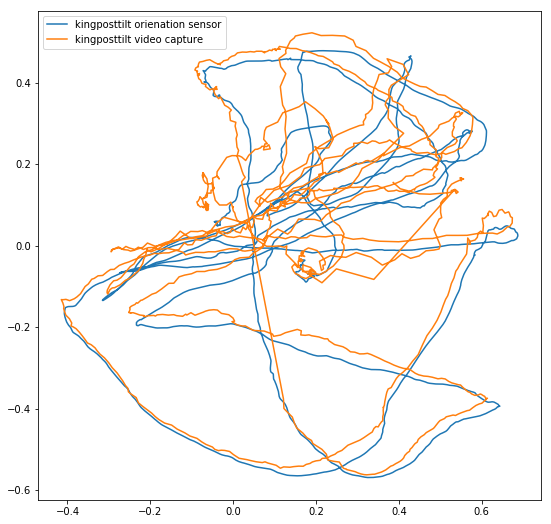

In [23]:
lpZ = fd.pZ[t0:t1].dropna()
plt.figure(figsize=(9,9))

import math
plt.plot(lpZ.tiltx, lpZ.tilty, label="kingposttilt orienation sensor")
theta = math.radians(78-2)
rrx = tiltv.rx*math.cos(theta) + tiltv.ry*math.sin(theta)
rry = tiltv.ry*math.cos(theta) - tiltv.rx*math.sin(theta)
plt.plot(rrx, rry, label="kingposttilt video capture")
plt.legend()

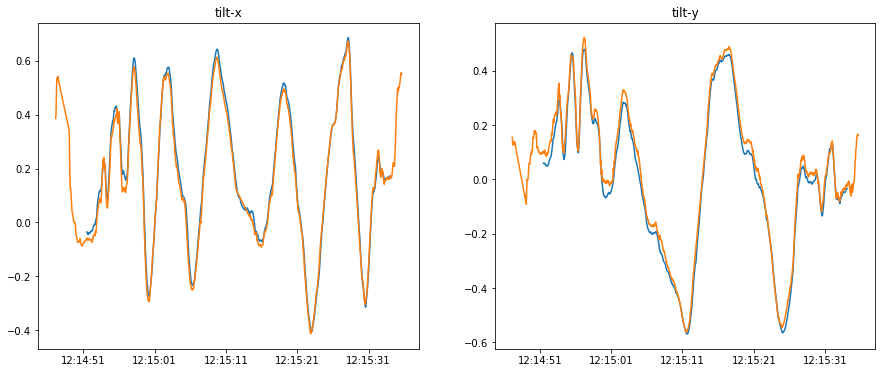

In [25]:
plt.figure(figsize=(15,6))
plt.subplot(121)
plt.plot(lpZ.tiltx)
plt.plot(tiltv.iloc[:-2].frametimes, rrx[:-2])
plt.title("tilt-x")

plt.subplot(122)
plt.plot(lpZ.tilty)
plt.plot(tiltv.iloc[:-2].frametimes, rry[:-2])
plt.title("tilt-y");
